* 환경 : Windows 10 이상, python 3.9 ( 아마 python 3.7 이상이면 동작할 거에요. ) 
* PC에 엔비디아 그래픽카드가 없다면 Catboost 실행이 안될 거에요. 그땐, Catboost 파라미터 중 task_tpye='GPU'를 지워주시면 돼요.
* GPU를 사용하지 않으면, PC의 CPU 자원을 모두 활용하기 때문에, PC가 멈출 수 있어요(렉이 심해지거나).
* 그럴 때는 thread_count=(모델이 활용하길 바라는 CPU 개수) ex) thread_count=5 (기본값은 thread_count=-1 로, -1은 모두 사용이란 의미입니다.)


In [ ]:
# # 라이브러리 설치이니 아래 코드들을 주석을 지운 뒤 실행시켜 주시면 돼요. (기존에 설치되어 있는 패키지는 스킵하고 설치됩니다.)
# # 주석을 한번에 지우는 방법 ----> 지우고 싶은 줄들을 드래그 하고, ctrl + '/' 를 누르면 한번에 지워져요.

# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install imblearn
# !pip install eli5
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno
# !pip install catboost
# !pip install optuna

In [40]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# progress bar in repeated code
from tqdm import tqdm
import pandas as pd
import numpy as np

# Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Scaling
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Permutation Importance
import eli5
from eli5.sklearn import PermutationImportance

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import seaborn as sns
import missingno as msno

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import f1_score

# Model & AutoML
import catboost
import optuna

In [41]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [42]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [43]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [44]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

In [45]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique()==0 or len(train_df[x].unique())==1: # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
    return train_df

train = remove_col(train)

In [46]:
train_x, train_y = train.drop(columns=['Y_Class', 'PRODUCT_ID', 'TIMESTAMP', 'Y_Quality']), train['Y_Class']
test = test[train_x.columns]

In [47]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


### catboost cv

In [9]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

* RepeatedStratifiedKFold를 활용하면 추후 test set의 결과를 추정할 수 있다.
* rskfold를 활용한 결과를 개선해나가는 것이 목표

In [11]:
rskfold = RepeatedStratifiedKFold(n_splits=7, n_repeats=2)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

14it [05:13, 22.41s/it]

0.5092731829573934 ~ 0.7709365721997301
mean : 0.6723316586148718


### 결측치 대체

#### Missingno

<AxesSubplot:>

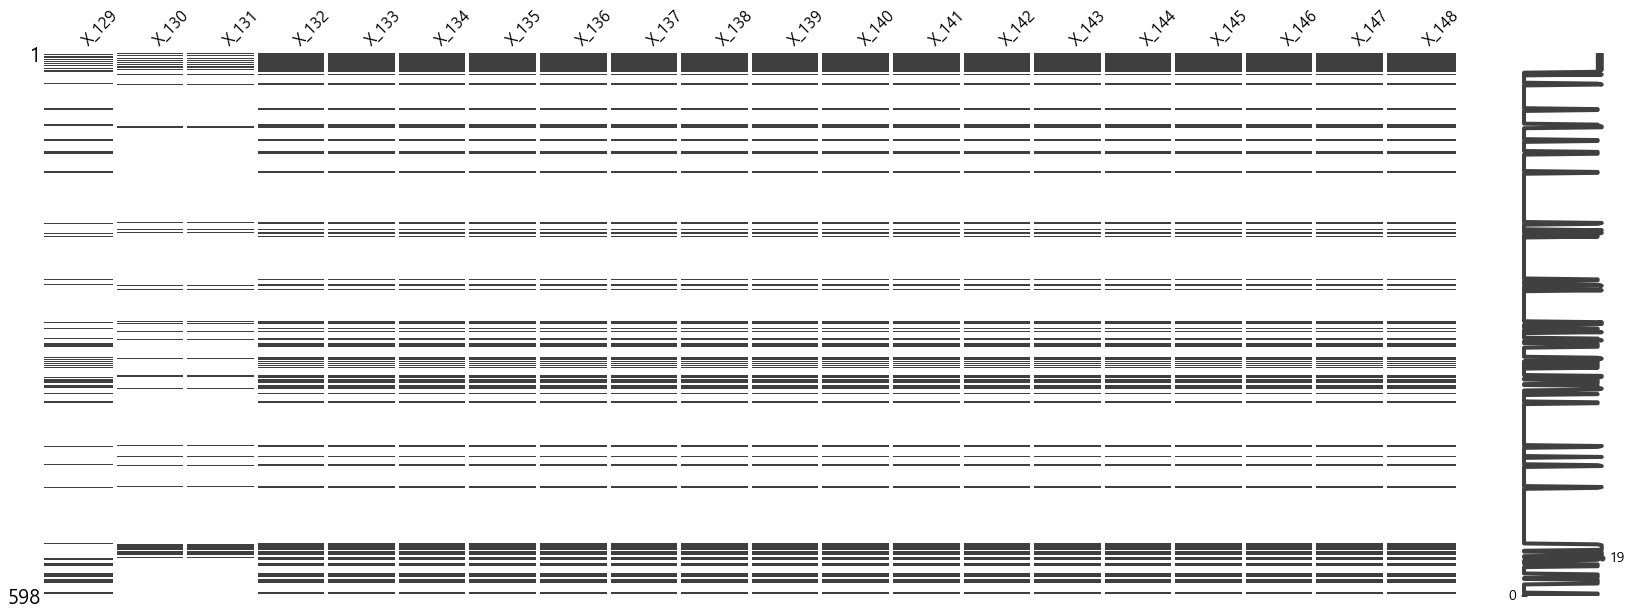

In [10]:
# 20개의 열만 뽑아 확인해 보았는데도 결측치가 굉장히 많다.
msno.matrix(train_x[train_x.columns[130:150]])

#### fillna(0)

* Catboost는 nan을 'string' 타입으로 치환하여 학습을 진행할 수 있다. 따라서 fillna(0)와 유사한 성능이 나타난다.
* MiceImputer, SimpleImputer 등 다양한 방법들을 활용해 보았지만, 성능향상에 도움이 되지 않았다.

In [48]:
train_x[train_x.columns[2:]] = train_x[train_x.columns[2:]].fillna(0)
test[test.columns[2:]] = test[test.columns[2:]].fillna(0)

### Feature importance

* Feature Importance는 학습된 모델에서 주로 사용된 컬럼들을 나타내기 때문에, 학습에 도움이 되지 않은 컬럼을 지워준다고 해도 
test predict에 영향력이 적다. 또한, 줄어든 컬럼으로 학습 방식이 바뀌고, overfit을 완화하여 더 나은 결과를 유도할 수 있다.

* Permutation Importance는 train_x에서 분할된 validation_set을 학습한 모델에서의 영향력을 보여주는 지표이다.
 validation set은 train으로부터 분리된 영역이므로 train에서의 영향력을 나타내는 지표이다.
 train에서는 여러 값이 존재하는 컬럼이 test에서는 nan만 존재하는 컬럼일 수 있다. 따라서 test set에서의 영향력을 판단하기 어렵다.
 그래서 permutation importance는 활용하지 않기로 한다.



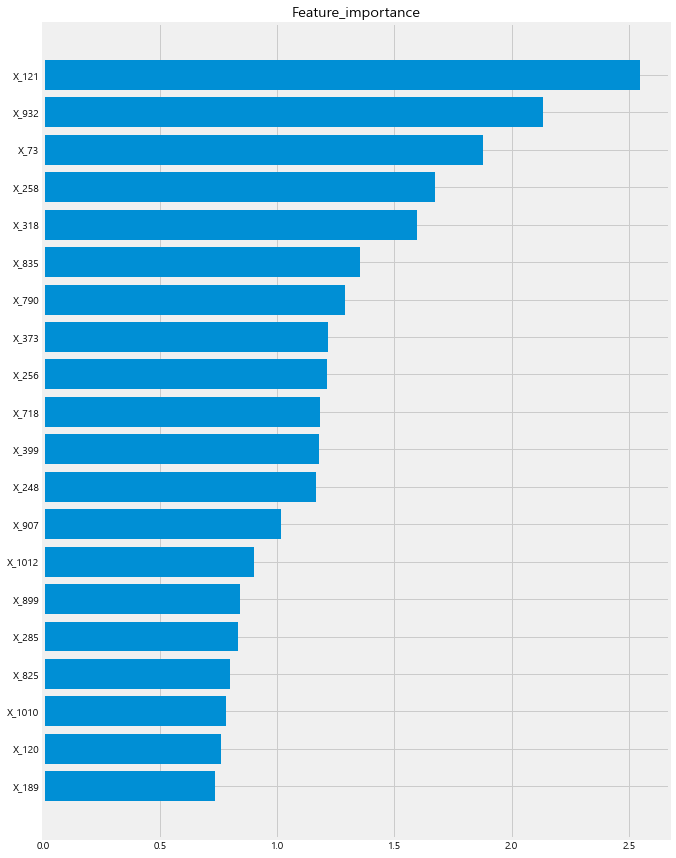

In [49]:
feat_list = []
for _ in range(10):
    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
    clf.fit(train_x, train_y, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

    feat_list.append(clf.feature_importances_)

feat_list = np.array(feat_list)
feat_max = np.array([max(feat_list[:, i]) for i in range(len(feat_list[0]))])
feature_imp = pd.Series(feat_max, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()
train_x = train_x[train_x.columns[feat_max>0]]
test = test[train_x.columns]

# Visualization
plt.rcParams["figure.figsize"] = (10, 15)

plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [62]:
train_x

,X_1,X_2,X_7,X_8,X_11,X_12,X_13,X_17,X_20,X_21,...,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2868
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,32.56
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,43.92
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.365517,104.0,193.4,179.820690,165.5,383.0,367.320755,353.0,39.19,42.47
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112.082759,94.5,190.3,181.920690,165.8,384.0,369.188679,353.0,37.74,52.17
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,138.066667,109.7,208.6,196.393333,182.6,383.0,367.351852,352.0,38.70,46.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,2.0,95.0,50.0,10.0,468.9,473.9,459.2,248.0,527.0,538.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.00
594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.527586,144.2,198.3,180.810345,168.7,384.0,369.811321,353.0,49.47,50.89
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,178.248276,159.6,186.5,176.486207,156.6,383.0,367.018868,352.0,0.00,0.00
596,40.0,94.0,45.0,10.0,505.8,510.9,497.1,248.1,489.0,498.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.00


In [63]:
# 영향력이 있는 모든 컬럼
for c in train_x.columns:
    print(f'"{c}"', end=', ')

"X_1", "X_2", "X_7", "X_8", "X_11", "X_12", "X_13", "X_17", "X_20", "X_21", "X_22", "X_24", "X_38", "X_39", "X_40", "X_41", "X_42", "X_43", "X_44", "X_45", "X_48", "X_49", "X_54", "X_55", "X_56", "X_58", "X_60", "X_61", "X_62", "X_63", "X_73", "X_90", "X_97", "X_98", "X_99", "X_101", "X_102", "X_103", "X_105", "X_106", "X_107", "X_109", "X_110", "X_111", "X_113", "X_114", "X_117", "X_118", "X_119", "X_120", "X_121", "X_123", "X_124", "X_125", "X_126", "X_127", "X_128", "X_129", "X_130", "X_131", "X_136", "X_137", "X_138", "X_139", "X_140", "X_141", "X_146", "X_149", "X_150", "X_152", "X_156", "X_176", "X_189", "X_201", "X_214", "X_217", "X_218", "X_221", "X_240", "X_242", "X_243", "X_247", "X_248", "X_250", "X_251", "X_256", "X_257", "X_258", "X_261", "X_262", "X_263", "X_265", "X_266", "X_267", "X_285", "X_286", "X_287", "X_289", "X_291", "X_292", "X_293", "X_294", "X_295", "X_300", "X_301", "X_303", "X_304", "X_306", "X_307", "X_308", "X_309", "X_310", "X_311", "X_318", "X_335", "X_3

In [9]:
# # 시도할 때마다 컬럼 수의 차이가 있다. 따라서 이 곳에 저장한 컬럼을 활용한다.
# feat_max = ["X_1", "X_2", "X_7", "X_8", "X_11", "X_12", "X_13", "X_17", "X_20", "X_21", "X_22", "X_39", "X_43", "X_45", "X_49", "X_56", "X_58", "X_60", "X_61", "X_62", "X_73", "X_90", "X_97", "X_98", "X_101", "X_102", "X_103", "X_105", "X_106", "X_107", "X_109", "X_110", "X_111", "X_113", "X_117", "X_118", "X_119", "X_120", "X_121", "X_123", "X_124", "X_125", "X_126", "X_127", "X_130", "X_131", "X_136", "X_137", "X_139", "X_140", "X_141", "X_149", "X_189", "X_201", "X_217", "X_221", "X_223", "X_228", "X_240", "X_242", "X_243", "X_247", "X_248", "X_256", "X_257", "X_258", "X_262", "X_265", "X_266", "X_267", "X_285", "X_286", "X_287", "X_289", "X_292", "X_293", "X_294", "X_300", "X_303", "X_307", "X_309", "X_318", "X_335", "X_338", "X_339", "X_344", "X_345", "X_346", "X_350", "X_354", "X_356", "X_364", "X_367", "X_368", "X_370", "X_372", "X_373", "X_374", "X_379", "X_380", "X_385", "X_387", "X_388", "X_389", "X_394", "X_396", "X_397", "X_398", "X_399", "X_400", "X_401", "X_402", "X_403", "X_404", "X_405", "X_406", "X_407", "X_408", "X_412", "X_413", "X_417", "X_419", "X_420", "X_421", "X_422", "X_423", "X_428", "X_435", "X_437", "X_438", "X_439", "X_440", "X_441", "X_442", "X_443", "X_445", "X_446", "X_447", "X_448", "X_449", "X_451", "X_452", "X_453", "X_454", "X_455", "X_456", "X_457", "X_458", "X_459", "X_460", "X_461", "X_462", "X_463", "X_464", "X_468", "X_470", "X_471", "X_472", "X_473", "X_474", "X_475", "X_476", "X_477", "X_478", "X_483", "X_484", "X_485", "X_486", "X_489", "X_490", "X_491", "X_492", "X_493", "X_494", "X_495", "X_496", "X_497", "X_498", "X_500", "X_501", "X_502", "X_507", "X_510", "X_512", "X_513", "X_514", "X_515", "X_516", "X_517", "X_520", "X_521", "X_523", "X_524", "X_525", "X_527", "X_528", "X_530", "X_531", "X_533", "X_534", "X_535", "X_536", "X_537", "X_539", "X_543", "X_544", "X_545", "X_546", "X_547", "X_548", "X_549", "X_550", "X_552", "X_553", "X_554", "X_555", "X_556", "X_557", "X_560", "X_562", "X_564", "X_565", "X_566", "X_568", "X_570", "X_571", "X_572", "X_573", "X_574", "X_576", "X_577", "X_580", "X_581", "X_582", "X_585", "X_587", "X_589", "X_590", "X_592", "X_594", "X_595", "X_596", "X_599", "X_601", "X_603", "X_604", "X_607", "X_608", "X_609", "X_611", "X_613", "X_614", "X_616", "X_618", "X_619", "X_622", "X_623", "X_624", "X_626", "X_627", "X_643", "X_644", "X_646", "X_647", "X_648", "X_649", "X_651", "X_652", "X_655", "X_657", "X_658", "X_659", "X_660", "X_661", "X_662", "X_663", "X_664", "X_665", "X_667", "X_668", "X_670", "X_671", "X_674", "X_677", "X_678", "X_679", "X_681", "X_682", "X_683", "X_686", "X_687", "X_688", "X_690", "X_694", "X_696", "X_697", "X_698", "X_700", "X_702", "X_704", "X_705", "X_706", "X_708", "X_709", "X_710", "X_711", "X_712", "X_713", "X_714", "X_716", "X_718", "X_720", "X_721", "X_722", "X_725", "X_726", "X_727", "X_731", "X_733", "X_734", "X_735", "X_736", "X_741", "X_742", "X_744", "X_745", "X_747", "X_748", "X_751", "X_753", "X_754", "X_757", "X_758", "X_762", "X_763", "X_766", "X_769", "X_771", "X_772", "X_773", "X_774", "X_775", "X_780", "X_781", "X_783", "X_785", "X_786", "X_788", "X_789", "X_790", "X_792", "X_793", "X_795", "X_796", "X_799", "X_800", "X_801", "X_802", "X_804", "X_810", "X_813", "X_814", "X_815", "X_816", "X_817", "X_818", "X_820", "X_824", "X_825", "X_827", "X_830", "X_831", "X_832", "X_833", "X_834", "X_835", "X_838", "X_840", "X_841", "X_846", "X_848", "X_852", "X_853", "X_854", "X_855", "X_856", "X_861", "X_863", "X_864", "X_866", "X_867", "X_871", "X_875", "X_876", "X_877", "X_878", "X_882", "X_883", "X_890", "X_891", "X_892", "X_893", "X_894", "X_895", "X_896", "X_897", "X_898", "X_899", "X_901", "X_907", "X_909", "X_911", "X_914", "X_916", "X_917", "X_918", "X_919", "X_921", "X_922", "X_923", "X_924", "X_925", "X_926", "X_927", "X_929", "X_931", "X_932", "X_941", "X_943", "X_945", "X_947", "X_948", "X_949", "X_953", "X_954", "X_955", "X_956", "X_957", "X_958", "X_959", "X_961", "X_963", "X_965", "X_966", "X_967", "X_968", "X_972", "X_973", "X_975", "X_976", "X_977", "X_979", "X_981", "X_982", "X_983", "X_984", "X_986", "X_991", "X_993", "X_994", "X_995", "X_996", "X_997", "X_999", "X_1001", "X_1002", "X_1010", "X_1012", "X_1014", "X_1015", "X_1016", "X_1017", "X_1018", "X_1019", "X_1026", "X_1028", "X_1029", "X_1030", "X_1033", "X_1034", "X_1036", "X_1037", "X_1038", "X_1040", "X_1043", "X_1044", "X_1045", "X_1046", "X_1047", "X_1048", "X_1049", "X_1053", "X_1054", "X_1055", "X_1056", "X_1058", "X_1059", "X_1063", "X_1064", "X_1065", "X_1067", "X_1072", "X_1073", "X_1074", "X_1076", "X_1078", "X_1080", "X_1081", "X_1082", "X_1084", "X_1086", "X_1088", "X_1089", "X_1091", "X_1097", "X_1099", "X_1100", "X_1101", "X_1105", "X_1106", "X_1107", "X_1108", "X_1109", "X_1110", "X_1111", "X_1112", "X_1114", "X_1115", "X_1116", "X_1117", "X_1118", "X_1120", "X_1121", "X_1122", "X_1123", "X_1124", "X_1125", "X_1126", "X_1127", "X_1129", "X_1133", "X_1135", "X_1138", "X_1143", "X_1147", "X_1151", "X_1152", "X_1154", "X_1155", "X_1156", "X_1158", "X_1159", "X_1160", "X_1161", "X_1162", "X_1163", "X_1165", "X_1166", "X_1172", "X_1175", "X_1176", "X_1178", "X_1179", "X_1182", "X_1183", "X_1184", "X_1186", "X_1189", "X_1190", "X_1192", "X_1194", "X_1196", "X_1197", "X_1198", "X_1199", "X_1202", "X_1203", "X_1207", "X_1208", "X_1210", "X_1211", "X_1213", "X_1214", "X_1218", "X_1220", "X_1223", "X_1225", "X_1226", "X_1227", "X_1228", "X_1229", "X_1231", "X_1232", "X_1239", "X_1240", "X_1243", "X_1244", "X_1245", "X_1256", "X_1257", "X_1258", "X_1260", "X_1262", "X_1263", "X_1265", "X_1271", "X_1274", "X_1275", "X_1276", "X_1279", "X_1280", "X_1281", "X_1285", "X_1286", "X_1287", "X_1288", "X_1289", "X_1291", "X_1297", "X_1300", "X_1301", "X_1304", "X_1306", "X_1310", "X_1313", "X_1315", "X_1321", "X_1322", "X_1324", "X_1325", "X_1326", "X_1327", "X_1330", "X_1331", "X_1332", "X_1333", "X_1335", "X_1336", "X_1337", "X_1338", "X_1340", "X_1341", "X_1343", "X_1345", "X_1346", "X_1347", "X_1348", "X_1350", "X_1352", "X_1353", "X_1354", "X_1356", "X_1357", "X_1359", "X_1365", "X_1366", "X_1369", "X_1371", "X_1373", "X_1374", "X_1375", "X_1376", "X_1378", "X_1379", "X_1380", "X_1381", "X_1382", "X_1388", "X_1389", "X_1391", "X_1401", "X_1405", "X_1406", "X_1408", "X_1409", "X_1410", "X_1416", "X_1418", "X_1419", "X_1420", "X_1422", "X_1423", "X_1424", "X_1425", "X_1427", "X_1428", "X_1429", "X_1430", "X_1433", "X_1437", "X_1439", "X_1441", "X_1442", "X_1445", "X_1455", "X_1459", "X_1463", "X_1464", "X_1469", "X_1470", "X_1473", "X_1476", "X_1477", "X_1479", "X_1485", "X_1489", "X_1492", "X_1494", "X_1495", "X_1498", "X_1499", "X_1500", "X_1507", "X_1512", "X_1515", "X_1516", "X_1518", "X_1520", "X_1521", "X_1526", "X_1527", "X_1528", "X_1530", "X_1532", "X_1534", "X_1536", "X_1539", "X_1541", "X_1542", "X_1543", "X_1545", "X_1546", "X_1548", "X_1550", "X_1552", "X_1553", "X_1554", "X_1557", "X_1558", "X_1560", "X_1562", "X_1563", "X_1564", "X_1566", "X_1567", "X_1569", "X_1570", "X_1588", "X_1595", "X_1601", "X_1608", "X_1611", "X_1612", "X_1616", "X_1617", "X_1618", "X_1621", "X_1625", "X_1626", "X_1630", "X_1633", "X_1634", "X_1635", "X_1639", "X_1642", "X_1646", "X_1647", "X_1649", "X_1651", "X_1652", "X_1658", "X_1665", "X_1669", "X_1671", "X_1679", "X_1694", "X_1697", "X_1703", "X_1704", "X_1706", "X_1714", "X_1715", "X_1716", "X_1718", "X_1725", "X_1734", "X_1740", "X_1743", "X_1744", "X_1745", "X_1746", "X_1748", "X_1750", "X_1751", "X_1756", "X_1758", "X_1762", "X_1768", "X_1770", "X_1774", "X_1776", "X_1786", "X_1787", "X_1793", "X_1794", "X_1800", "X_1804", "X_1806", "X_1810", "X_1812", "X_1817", "X_1818", "X_1824", "X_1826", "X_1832", "X_1834", "X_1849", "X_1856", "X_1858", "X_1866", "X_1874", "X_1877", "X_1880", "X_1884", "X_1886", "X_1888", "X_1894", "X_1916", "X_1917", "X_1919", "X_1924", "X_1926", "X_1930", "X_1931", "X_1934", "X_1940", "X_1942", "X_1945", "X_1946", "X_1948", "X_1949", "X_1951", "X_1953", "X_1954", "X_1955", "X_1956", "X_1958", "X_1959", "X_1961", "X_1965", "X_1966", "X_1969", "X_1972", "X_2000", "X_2012", "X_2013", "X_2017", "X_2018", "X_2019", "X_2022", "X_2026", "X_2027", "X_2028", "X_2041", "X_2044", "X_2047", "X_2048", "X_2049", "X_2050", "X_2051", "X_2057", "X_2058", "X_2062", "X_2063", "X_2066", "X_2069", "X_2070", "X_2072", "X_2075", "X_2077", "X_2080", "X_2082", "X_2084", "X_2085", "X_2086", "X_2087", "X_2090", "X_2093", "X_2094", "X_2095", "X_2096", "X_2099", "X_2100", "X_2103", "X_2105", "X_2122", "X_2154", "X_2168", "X_2190", "X_2191", "X_2203", "X_2240", "X_2257", "X_2258", "X_2261", "X_2274", "X_2282", "X_2315", "X_2316", "X_2336", "X_2347", "X_2348", "X_2387", "X_2408", "X_2409", "X_2411", "X_2412", "X_2415", "X_2421", "X_2422", "X_2423", "X_2428", "X_2429", "X_2430", "X_2431", "X_2434", "X_2449", "X_2455", "X_2466", "X_2470", "X_2471", "X_2472", "X_2480", "X_2515", "X_2529", "X_2535", "X_2541", "X_2542", "X_2552", "X_2553", "X_2554", "X_2555", "X_2577", "X_2608", "X_2700", "X_2701", "X_2705", "X_2707", "X_2710", "X_2714", "X_2715", "X_2716", "X_2717", "X_2721", "X_2724", "X_2725", "X_2728", "X_2731", "X_2735", "X_2736", "X_2743", "X_2744", "X_2747", "X_2756", "X_2761", "X_2779", "X_2780", "X_2782", "X_2788", "X_2790", "X_2793", "X_2797", "X_2800", "X_2801", "X_2808", "X_2810", "X_2839", "X_2841", "X_2846", "X_2852", "X_2853", "X_2855", "X_2857", "X_2860", "X_2862", "X_2864", "X_2865"]
# train_x = train_x[feat_max]
# test = test[feat_max]

In [52]:
test_y = pd.read_csv('submission_36_feat_del.csv').Y_Class

In [53]:
def cb_objective(trial):

    params = {
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',1e-8,10),
            'depth': trial.suggest_int('depth',3,12),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            "eval_metric": 'TotalF1',
            "one_hot_max_size": trial.suggest_int("one_hot_max_size",1,3),
            'task_type': 'GPU',
        }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature',0,10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample',0.1,1)
    
    
    clf = catboost.CatBoostClassifier(**params)
    clf.fit(train_x, train_y)
    pred = clf.predict(test)

    return f1_score(pred, test_y, average='macro')

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=100, show_progress_bar=True)

[I 2023-03-02 21:15:50,377] A new study created in memory with name: no-name-004c6b5d-f4e5-4dd5-8278-c252ad413a06


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-03-02 21:16:11,752] Trial 0 finished with value: 0.7516773694529887 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 524, 'learning_rate': 0.04608478312257003, 'reg_lambda': 21.852305194804728, 'random_strength': 7.963941636861126, 'depth': 3, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 2, 'bagging_temperature': 0.5665105656940983}. Best is trial 0 with value: 0.7516773694529887.
[I 2023-03-02 21:18:25,161] Trial 1 finished with value: 0.7687097184324542 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 531, 'learning_rate': 0.0743499319765141, 'reg_lambda': 21.186915319226447, 'random_strength': 5.54653879829537, 'depth': 10, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 1, 'one_hot_max_size': 1, 'subsample': 0.8774376339056253}. Best is trial 1 with value: 0.7687097184324542.
[I 2023-03-02 21:18:44,226] Trial 2 finished with value: 0.6996276717411747 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 542, 'learn

[I 2023-03-02 21:38:00,024] Trial 19 finished with value: 0.8386079069308883 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 835, 'learning_rate': 0.028590277518267135, 'reg_lambda': 81.0740285459043, 'random_strength': 4.399323074142472, 'depth': 8, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 2, 'bagging_temperature': 1.607719763564846}. Best is trial 6 with value: 0.8757818096999382.
[I 2023-03-02 21:38:21,479] Trial 20 finished with value: 0.6867479518689196 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 925, 'learning_rate': 0.08661377654168073, 'reg_lambda': 47.444561146517174, 'random_strength': 1.1963146969909046, 'depth': 3, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 1, 'bagging_temperature': 3.8984184104592146}. Best is trial 6 with value: 0.8757818096999382.
[I 2023-03-02 21:39:20,142] Trial 21 finished with value: 0.6848760783239763 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait

[I 2023-03-02 21:51:21,667] Trial 38 finished with value: 0.8621067002730518 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 509, 'learning_rate': 0.023378679241638996, 'reg_lambda': 81.63030541019424, 'random_strength': 2.4562621402179765, 'depth': 6, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 1, 'bagging_temperature': 2.2260087710510934}. Best is trial 31 with value: 0.9074486470782679.
[I 2023-03-02 21:51:47,682] Trial 39 finished with value: 0.7309380474597865 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 1000, 'learning_rate': 0.06211035891173876, 'reg_lambda': 25.597132660891045, 'random_strength': 0.6468520498035768, 'depth': 6, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 9, 'one_hot_max_size': 1, 'bagging_temperature': 3.575786740455621}. Best is trial 31 with value: 0.9074486470782679.
[I 2023-03-02 21:52:03,832] Trial 40 finished with value: 0.7215013958004612 and parameters: {'bootstrap_type': 'Bernoulli', 'od

[I 2023-03-02 22:01:59,978] Trial 57 finished with value: 0.7980568945670834 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 562, 'learning_rate': 0.036380465736379715, 'reg_lambda': 85.30987580954798, 'random_strength': 0.21058844707617208, 'depth': 7, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 7, 'one_hot_max_size': 1, 'bagging_temperature': 2.7803327647448084}. Best is trial 51 with value: 0.937401746236593.
[I 2023-03-02 22:03:10,068] Trial 58 finished with value: 0.8363425925925926 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 632, 'learning_rate': 0.0577945353761076, 'reg_lambda': 90.9404250702514, 'random_strength': 1.2677120785950384, 'depth': 9, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 2, 'one_hot_max_size': 1, 'bagging_temperature': 1.5675819872043633}. Best is trial 51 with value: 0.937401746236593.
[I 2023-03-02 22:03:57,602] Trial 59 finished with value: 0.5436782312508923 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wai

[I 2023-03-02 22:12:16,538] Trial 76 finished with value: 0.8422592917764119 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 950, 'learning_rate': 0.027542544572686196, 'reg_lambda': 45.27275620339827, 'random_strength': 3.383978021055963, 'depth': 5, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 1, 'bagging_temperature': 1.1437927409953867}. Best is trial 51 with value: 0.937401746236593.
[I 2023-03-02 22:12:44,678] Trial 77 finished with value: 0.7391087861346861 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 525, 'learning_rate': 0.03927209824365754, 'reg_lambda': 87.81110537793386, 'random_strength': 2.4313657387364302, 'depth': 6, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'one_hot_max_size': 1, 'subsample': 0.25175474995526065}. Best is trial 51 with value: 0.937401746236593.
[I 2023-03-02 22:13:20,351] Trial 78 finished with value: 0.756469278978504 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 900, '

[I 2023-03-02 22:29:03,895] Trial 95 finished with value: 0.9077488359151875 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 593, 'learning_rate': 0.04133072326117567, 'reg_lambda': 91.42043088968327, 'random_strength': 2.0302760889823994, 'depth': 6, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 4, 'one_hot_max_size': 1, 'bagging_temperature': 2.4481952028079776}. Best is trial 85 with value: 0.9404826815050726.
[I 2023-03-02 22:29:33,284] Trial 96 finished with value: 0.9033160993326163 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 589, 'learning_rate': 0.033841371450981775, 'reg_lambda': 89.84263831047691, 'random_strength': 2.00572076138836, 'depth': 7, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 4, 'one_hot_max_size': 1, 'bagging_temperature': 1.726083428979025}. Best is trial 85 with value: 0.9404826815050726.
[I 2023-03-02 22:30:03,546] Trial 97 finished with value: 0.6866666666666666 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait

In [55]:
# 결과값 비교
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [56]:
# 선택된 파라미터 조합 비교
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [57]:
# 가장 영향력이 큰 파라미터
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [58]:
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0, task_type="GPU").fit(train_x, train_y, early_stopping_rounds=100)
pred = clf.predict(test)

In [59]:
subm['Y_Class'] = pred
subm.Y_Class.value_counts()

1    265
0     38
2      7
Name: Y_Class, dtype: int64

In [ ]:
subm.to_csv('./submission_65.csv', index=False)

In [60]:
f1_score(pred, test_y, average='macro')

0.9362433407802029

In [61]:
for i, (a, b) in enumerate(zip(pred, pd.read_csv('submission_36_feat_del.csv').Y_Class)):
    if a[0] != b:
        print(i, a[0], b)

1 2 1
61 0 1
132 1 0
151 1 2
282 1 0


In [65]:
clf.save_model('submission_65.cbm', format='cbm')

In [66]:
clf = catboost.CatBoostClassifier()
clf.load_model('submission_65.cbm')
clf.fit(train_x, train_y)
pred = clf.predict(test)

In [67]:
f1_score(pred, test_y, average='macro')

0.9443071106587174

In [68]:
for i, (a, b) in enumerate(zip(pred, pd.read_csv('submission_36_feat_del.csv').Y_Class)):
    if a[0] != b:
        print(i, a[0], b)

54 1 0
61 0 1
132 1 0
151 1 2
282 1 0
283 0 1
286 0 1
